# Georeferenciación Galeria Inmobiliaria

## Cargue de librerías

En esta sección se realiza el cargue de las librerías necesarias para el procesamiento de los datos

In [311]:
import pandas as pd
import requests
import json
import time
import swifter
import geopandas as gpd
from shapely.geometry import Point
import shapely.wkt
import matplotlib
import unicodedata

## Configuración y parametrización

En esta sección se definen los parámetros básicos de visualización de los dataframes, se establecen las direcciones de los servicios web a consumir y se definen las variables para establecer las hojas de interés dentro de cada archivo y los campos a georeferenciar en cada caso.

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
#URL geocodificador
url = "https://catalogopmb.catastrobogota.gov.co/PMBWeb/web/api"

In [4]:
path_vivienda_usada = 'MAYO/Bogota_Programa_Vivienda_Usada_05-23.xlsb'
sheets_vivienda_usada = ['Sop. Venta', 'Sop. Arriendos']
vivienda_usada_dir = 'Dirección Nueva' 
path_comercio = 'MAYO/Bogota_Comercio_Def_05-23.xlsb'
sheets_comercio = ['Base Proyecto', 'Base Inmuebles', 'Base Historia']
comercio_dir = 'Dirección'
path_def = 'MAYO/Bogota_Def_05-23.xlsb'
sheets_def = ['Base Proyectos']
def_dir = 'Dirección'

## Cargue de insumos

En esta sección se realiza el cargue de los diferentes insumos para su posterior procesamiento. Adicionalmente, se parametrizan las funciones de cargue a partir de la estructura y definición de cada una de las fuentes.

In [5]:
df_vivienda_usada_venta = pd.read_excel(path_vivienda_usada, sheet_name=sheets_vivienda_usada[0], skiprows=4)

In [6]:
df_vivienda_usada_arriendo = pd.read_excel(path_vivienda_usada, sheet_name=sheets_vivienda_usada[1], skiprows=4)

In [7]:
df_comercio_base_proyecto = pd.read_excel(path_comercio, sheet_name=sheets_comercio[0])

In [8]:
df_comercio_base_inmuebles = pd.read_excel(path_comercio, sheet_name=sheets_comercio[1])
df_comercio_base_inmuebles = df_comercio_base_inmuebles.drop([0])

In [9]:
df_comercio_base_historia = pd.read_excel(path_comercio, sheet_name=sheets_comercio[2])

In [10]:
df_def_base_proyecto = pd.read_excel(path_def, sheet_name=sheets_def[0])

## Funciones

En esta sección se definen las funciones que se van a utilizar para el procesamiento de los datos

### Función georeferenciar

La función georeferenciar se encarga de obtener a partir del uso de un servicio web externo las coordenadas geográficas de una dirección entregada por parámetro.

In [312]:
def georeferenciar(input_str:str):
    """
    Realiza la georreferenciación de una cadena de entrada utilizando una API de geocodificación.

    Args:
        input_str (str): La cadena a georreferenciar.

    Returns:
        dict: Un diccionario que contiene los datos de georreferenciación si la operación fue exitosa.
              En caso contrario, devuelve un diccionario que indica un estado de falla o un estado de error.

    """
    direc = unicodedata.normalize("NFKD", input_str).encode("ascii","ignore").decode("ascii").lower()
    val = [True for t in direc.replace('.','').split() if t in ['km','chia','cota','tocancipa','tenjo','madrid','tabio,','cajica,','mosquera','zipaquira']]
    if sum(val)>=1:
        return {'estado': 'outside_bogota'}
    else:
        try:
            params = {
                'cmd': 'geocodificar',
                'apikey': '1c025f92-4520-49c1-90a7-a24b3d9d374c',
                'query': input_str
            }

            response = requests.get(url, params=params)
            res = response.json()
            success = res['response']['success']
            if success:
                data = res['response']['data']
                return data
            else:
                return {'estado': 'failed'}
        except:
            return {'estado': 'error_ws'}

In [116]:
def distance(p1: Point, p2: Point):
     """
    Calcula la distancia entre dos puntos geográficos.

    Args:
        p1 (Point): El primer punto geográfico en formato `Point`.
        p2 (Point): El segundo punto geográfico en formato `Point`.

    Returns:
        Series: Una serie que contiene la distancia entre los dos puntos en la proyección UTM.

    """
    gdf_1 = gpd.GeoDataFrame(geometry=[shapely.wkt.loads(str(p1))], crs="EPSG:4326")
    gdf_2 = gpd.GeoDataFrame(geometry=[shapely.wkt.loads(str(p2))], crs="EPSG:4326")
    utm = gdf_1.estimate_utm_crs()
    return gdf_1.to_crs(utm).distance(gdf_2.to_crs(utm))

## Exploración

Para utilizar la función de georeferenciación se va a realizar un muestreo aleatorio de direcciones con el fin de evaluar la calidad de el API geográfico. Esta exploración va a permitir identificar que tipo de ajustes se deben realizar a las direcciones de las bases de datos a georeferenciar.

In [12]:
sample_1 = df_vivienda_usada_venta.sample(n=150, random_state=1)[vivienda_usada_dir].reset_index()
sample_1['addr'] = sample_1[vivienda_usada_dir]
sample_1['source']='df_vivienda_usada_venta'
del sample_1[vivienda_usada_dir]
del sample_1['index']
sample_1['geocode_result'] = sample_1['addr'].swifter.apply(georeferenciar)

Pandas Apply:   0%|          | 0/150 [00:00<?, ?it/s]

In [66]:
sample_1['estado'] = sample_1.apply(lambda x: json.loads(x['geocode_result'])['estado'] if type(x['geocode_result']) is str else x['geocode_result']['estado'], axis=1)
sample_1['tipo_direccion'] = sample_1.apply(lambda x: None if type(x['geocode_result']) is str else x['geocode_result']['tipo_direccion'], axis=1)
sample_1['lat'] = sample_1.apply(lambda x: None if type(x['geocode_result']) is str else x['geocode_result']['yinput'], axis=1)
sample_1['lng'] = sample_1.apply(lambda x: None if type(x['geocode_result']) is str else x['geocode_result']['xinput'], axis=1)

In [67]:
pd.set_option('display.max_rows', None)

In [68]:
sample_1

,addr,source,geocode_result,estado,lat,lng,tipo_direccion
0,Cr. 37 # 57-44,df_vivienda_usada_venta,"{'estado': 'success', 'yinput': 4.647198757000...",success,4.647199,-74.081780,Asignada por Catastro
1,Cr. 51 # 102A - 49,df_vivienda_usada_venta,"{'estado': 'success', 'yinput': 4.690782262000...",success,4.690782,-74.062103,Asignada por Catastro
2,Cr. 6 # 80-23,df_vivienda_usada_venta,"{'estado': 'success', 'yinput': 4.661167180000...",success,4.661167,-74.049579,Asignada por Catastro
3,Av. Cr. 9 # 104-07,df_vivienda_usada_venta,"{'estado': 'success', 'yinput': 4.687574692, '...",success,4.687575,-74.044010,Asignada por Catastro
4,Cr. 14 # 127-30,df_vivienda_usada_venta,"{'estado': 'success', 'yinput': 4.704591983, '...",success,4.704592,-74.040797,Asignada por Catastro
5,Cr. 14B # 119-71,df_vivienda_usada_venta,"{'estado': 'success', 'yinput': 4.700073057999...",success,4.700073,-74.042178,Asignada por Catastro
6,Cr. 14A # 117-05,df_vivienda_usada_venta,"{'estado': 'success', 'yinput': 4.696824782000...",success,4.696825,-74.041578,Asignada por Catastro
7,Cl. 134A # 19A-44,df_vivienda_usada_venta,"{'estado': 'success', 'yinput': 4.719385480000...",success,4.719385,-74.048449,Asignada por Catastro
8,Av. Cl. 116 # 20-16,df_vivienda_usada_venta,"{'estado': 'success', 'yinput': 4.699111399, '...",success,4.699111,-74.051802,Asignada por Catastro
9,Cl. 78 # 7-79,df_vivienda_usada_venta,"{'estado': 'success', 'yinput': 4.660600176999...",success,4.660600,-74.052385,Asignada por Catastro


In [69]:
pd.set_option('display.max_rows', 10)

El 0.6% de la muestra aleatoria del primer dataframe (df_vivienda_usada_venta) no pudo ser georeferenciado por la existencia de detalles en la dirección utilizada como insumo.

In [13]:
sample_2 = df_vivienda_usada_arriendo.sample(n=150, random_state=1)[vivienda_usada_dir].reset_index()
sample_2['addr'] = sample_2[vivienda_usada_dir]
sample_2['source']='df_vivienda_usada_arriendo'
del sample_2[vivienda_usada_dir]
del sample_2['index']
sample_2['geocode_result'] = sample_2['addr'].swifter.apply(georeferenciar)

Pandas Apply:   0%|          | 0/150 [00:00<?, ?it/s]

In [70]:
sample_2['estado'] = sample_2.apply(lambda x: json.loads(x['geocode_result'])['estado'] if type(x['geocode_result']) is str else x['geocode_result']['estado'], axis=1)
sample_2['tipo_direccion'] = sample_2.apply(lambda x: None if type(x['geocode_result']) is str else x['geocode_result']['tipo_direccion'], axis=1)
sample_2['lat'] = sample_2.apply(lambda x: None if type(x['geocode_result']) is str else x['geocode_result']['yinput'], axis=1)
sample_2['lng'] = sample_2.apply(lambda x: None if type(x['geocode_result']) is str else x['geocode_result']['xinput'], axis=1)

In [71]:
pd.set_option('display.max_rows', None)

In [72]:
sample_2

,addr,source,geocode_result,estado,lat,lng,tipo_direccion
0,Cr. 5 # 72-38,df_vivienda_usada_arriendo,"{'estado': 'success', 'yinput': 4.654720348000...",success,4.654720,-74.053364,Dirección antigua
1,Av. Cr. 7 # 82-62,df_vivienda_usada_arriendo,"{'estado': 'success', 'yinput': 4.663197007000...",success,4.663197,-74.048255,Asignada por Catastro
2,Cr. 2A # 72-12,df_vivienda_usada_arriendo,"{'estado': 'success', 'yinput': 4.653672495000...",success,4.653672,-74.051925,Dirección antigua
3,Tr. 56 # 108 - 05,df_vivienda_usada_arriendo,"{'estado': 'success', 'yinput': 4.696132332999...",success,4.696132,-74.065863,Asignada por Catastro
4,Cl. 146 # 19-93,df_vivienda_usada_arriendo,"{'estado': 'success', 'yinput': 4.728528428, '...",success,4.728528,-74.047574,Asignada por Catastro
5,Cl. 107a # 11a-87,df_vivienda_usada_arriendo,"{'estado': 'success', 'yinput': 4.689785589, '...",success,4.689786,-74.041800,Asignada por Catastro
6,Cr. 58C # 152B-66,df_vivienda_usada_arriendo,"{'estado': 'success', 'yinput': 4.740506326, '...",success,4.740506,-74.062684,Asignada por Catastro
7,Cr. 54C # 143A-90,df_vivienda_usada_arriendo,"{'estado': 'success', 'yinput': 4.728877289000...",success,4.728877,-74.057771,Asignada por Catastro
8,Cl. 23A # 58-40,df_vivienda_usada_arriendo,"{'estado': 'success', 'yinput': 4.642932936000...",success,4.642933,-74.102133,Asignada por Catastro
9,Cr. 23 # 137-48/45,df_vivienda_usada_arriendo,"{'estado': 'success', 'yinput': 4.722911628000...",success,4.722912,-74.050022,Asignada por Catastro


In [73]:
pd.set_option('display.max_rows', 10)

El 0.6% de la muestra aleatoria del segundo dataframe (df_vivienda_usada_arriendo)  no se pudo georeferenciar debido a que el API de geocodificación no encontro coincidencias para la dirección.

In [313]:
sample_3 = df_comercio_base_proyecto[df_comercio_base_proyecto['Ciudad']=='Bogota'].sample(n=150, random_state=1)[comercio_dir].reset_index()
sample_3['addr'] = sample_3[comercio_dir]
sample_3['source']='df_comercio_base_proyecto'
del sample_3[comercio_dir]
del sample_3['index']
sample_3['geocode_result'] = sample_3['addr'].swifter.apply(georeferenciar)

Pandas Apply:   0%|          | 0/150 [00:00<?, ?it/s]

In [314]:
sample_3['estado'] = sample_3.apply(lambda x: x['geocode_result']['estado'], axis=1)
sample_3['tipo_direccion'] = sample_3.apply(lambda x: None if x['geocode_result']['estado']!='success' else x['geocode_result']['tipo_direccion'], axis=1)
sample_3['lat'] = sample_3.apply(lambda x: None if x['geocode_result']['estado']!='success' else x['geocode_result']['yinput'], axis=1)
sample_3['lng'] = sample_3.apply(lambda x: None if x['geocode_result']['estado']!='success' else x['geocode_result']['xinput'], axis=1)

In [315]:
pd.set_option('display.max_rows', None)

In [316]:
sample_3

,addr,source,geocode_result,estado,tipo_direccion,lat,lng
0,Cl. 13 # 65-71,df_comercio_base_proyecto,"{'estado': 'success', 'yinput': 4.634684462999...",success,Dirección antigua,4.634684,-74.115410
1,Autonorte # 106 - 71,df_comercio_base_proyecto,{'estado': 'failed'},failed,None,NaN,NaN
2,Cr. 14 # 96-35,df_comercio_base_proyecto,"{'estado': 'success', 'yinput': 4.681524895999...",success,Dirección por aproximación,4.681525,-74.048591
3,Vereda Canavita Tocancipa,df_comercio_base_proyecto,{'estado': 'outside_bogota'},outside_bogota,None,NaN,NaN
4,Cl 134a # 19 -15,df_comercio_base_proyecto,"{'estado': 'success', 'yinput': 4.719060010000...",success,Asignada por Catastro,4.719060,-74.047144
5,Av Caracas # 49- 51 Sur,df_comercio_base_proyecto,{'estado': 'failed'},failed,None,NaN,NaN
6,Tr. 59 # 104B-86,df_comercio_base_proyecto,"{'estado': 'success', 'yinput': 4.693365862000...",success,Asignada por Catastro,4.693366,-74.066374
7,Cr. 11B # 96-79,df_comercio_base_proyecto,"{'estado': 'success', 'yinput': 4.680622310999...",success,Asignada por Catastro,4.680622,-74.046154
8,Cr. 11 # 93A-53,df_comercio_base_proyecto,"{'estado': 'success', 'yinput': 4.676545655999...",success,Asignada por Catastro,4.676546,-74.046677
9,"Vía Siberia Km. 9,5",df_comercio_base_proyecto,{'estado': 'outside_bogota'},outside_bogota,None,NaN,NaN


In [317]:
pd.set_option('display.max_rows', 10)

In [318]:
sample_3['estado'].value_counts(normalize=True)

estado
success           0.553333
failed            0.286667
outside_bogota    0.160000
Name: proportion, dtype: float64

El 28% de la muestra aleatoria del tercer dataframe (df_comercio_base_proyecto)  no pudo ser georeferenciada por las siguientes razones:
* Nombres de vías que no son aceptados por el API
* Detalles de texto en la dirección
* Referencia a lugares especificos (no direcciones)

Hay un 16% adicional que hace referencia a direcciones fuera de Bogotá (en otras ciudades o en vías nacionales)

In [319]:
sample_4 = df_comercio_base_inmuebles[df_comercio_base_inmuebles['Ciudad']=='Bogota'].sample(n=150, random_state=1)[comercio_dir].reset_index()
sample_4['addr'] = sample_4[comercio_dir]
sample_4['source']='df_comercio_base_inmuebles'
del sample_4[comercio_dir]
del sample_4['index']
sample_4['geocode_result'] = sample_4['addr'].swifter.apply(georeferenciar)

Pandas Apply:   0%|          | 0/150 [00:00<?, ?it/s]

In [320]:
sample_4['estado'] = sample_4.apply(lambda x: x['geocode_result']['estado'], axis=1)
sample_4['tipo_direccion'] = sample_4.apply(lambda x: None if x['geocode_result']['estado']!='success' else x['geocode_result']['tipo_direccion'], axis=1)
sample_4['lat'] = sample_4.apply(lambda x: None if x['geocode_result']['estado']!='success' else x['geocode_result']['yinput'], axis=1)
sample_4['lng'] = sample_4.apply(lambda x: None if x['geocode_result']['estado']!='success' else x['geocode_result']['xinput'], axis=1)

In [321]:
pd.set_option('display.max_rows', None)

In [322]:
sample_4

,addr,source,geocode_result,estado,tipo_direccion,lat,lng
0,Km 28 Vía Cajicá 50 mts antes de San Jeronimo,df_comercio_base_inmuebles,{'estado': 'outside_bogota'},outside_bogota,None,NaN,NaN
1,Av. Cl. 26-96J-90,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.687553716000...",success,Asignada por Catastro,4.687554,-74.127484
2,Av. 19 # 116-71,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.698798936999...",success,Dirección por aproximación,4.698799,-74.049744
3,Calle 140 # 10A-48,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.718609199000...",success,Asignada por Catastro,4.718609,-74.034503
4,Cl 90 # 16 -09,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.674845720000...",success,Asignada por Catastro,4.674846,-74.054029
5,Av. Cl. 26-96J-90,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.687553716000...",success,Asignada por Catastro,4.687554,-74.127484
6,Cl. 18 # 77- 51,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.654305454999...",success,Asignada por Catastro,4.654305,-74.130101
7,Km 19 Vía Bogotá Mosquera,df_comercio_base_inmuebles,{'estado': 'outside_bogota'},outside_bogota,None,NaN,NaN
8,Vía Mosquera Bogotá,df_comercio_base_inmuebles,{'estado': 'outside_bogota'},outside_bogota,None,NaN,NaN
9,Av. Cl. 24 # 95A-80,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.680582147999...",success,Dirección por aproximación,4.680582,-74.125189


In [323]:
pd.set_option('display.max_rows', 10)

In [324]:
sample_4['estado'].value_counts(normalize=True)

estado
success           0.600000
failed            0.226667
outside_bogota    0.173333
Name: proportion, dtype: float64

El 22% de la muestra aleatoria del cuarto dataframe (df_comercio_base_inmuebles) no pudo ser georeferenciada por las siguientes razones:

* Nombres de vías que no son aceptados por el API
* Detalles de texto en la dirección
* Referencia a lugares especificos (no direcciones)

Hay un 17% adicional que hace referencia a direcciones fuera de Bogotá (en otras ciudades o en vías nacionales)

In [325]:
sample_5 = df_comercio_base_historia[df_comercio_base_historia['Ciudad']=='Bogota'].sample(n=150, random_state=1)[comercio_dir].reset_index()
sample_5['addr'] = sample_5[comercio_dir]
sample_5['source']='df_comercio_base_inmuebles'
del sample_5[comercio_dir]
del sample_5['index']
sample_5['geocode_result'] = sample_5['addr'].swifter.apply(georeferenciar)

Pandas Apply:   0%|          | 0/150 [00:00<?, ?it/s]

In [326]:
sample_5['estado'] = sample_5.apply(lambda x: x['geocode_result']['estado'], axis=1)
sample_5['tipo_direccion'] = sample_5.apply(lambda x: None if x['geocode_result']['estado']!='success' else x['geocode_result']['tipo_direccion'], axis=1)
sample_5['lat'] = sample_5.apply(lambda x: None if x['geocode_result']['estado']!='success' else x['geocode_result']['yinput'], axis=1)
sample_5['lng'] = sample_5.apply(lambda x: None if x['geocode_result']['estado']!='success' else x['geocode_result']['xinput'], axis=1)

In [327]:
pd.set_option('display.max_rows', None)

In [328]:
sample_5

,addr,source,geocode_result,estado,tipo_direccion,lat,lng
0,Cr. 7 # 127-48,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.703301173, '...",success,Asignada por Catastro,4.703301,-74.028527
1,Cr 5 # 20- 39,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.605686901000...",success,Asignada por Catastro,4.605687,-74.069746
2,Cl. 114 # 9-02,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.692716659999...",success,Dirección antigua,4.692717,-74.034414
3,Cl. 127 # 19A-14/20,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.705969243000...",success,Asignada por Catastro,4.705969,-74.049680
4,Km 1.4 Vía Chía Cota,df_comercio_base_inmuebles,{'estado': 'outside_bogota'},outside_bogota,None,NaN,NaN
5,Cr 15 # 77 -50,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.664189764000...",success,Asignada por Catastro,4.664190,-74.058243
6,Av. 19 # 97-51,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.684095921999...",success,Dirección por aproximación,4.684096,-74.052213
7,Cr. 13A # 30-21,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.619211441999...",success,Dirección por aproximación,4.619211,-74.072849
8,Cr. 91 # 135-56,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.733999166999...",success,Asignada por Catastro,4.733999,-74.085664
9,Cl. 15B # 116-21,df_comercio_base_inmuebles,"{'estado': 'success', 'yinput': 4.683228964000...",success,Dirección por aproximación,4.683229,-74.155932


In [329]:
pd.set_option('display.max_rows', 10)

In [330]:
sample_5['estado'].value_counts(normalize=True)

estado
success           0.56
failed            0.24
outside_bogota    0.20
Name: proportion, dtype: float64

El 24% de la muestra aleatoria del quinto dataframe (df_comercio_base_historia) no pudo ser georeferenciada por las siguientes razones:

* Nombres de vías que no son aceptados por el API
* Detalles de texto en la dirección
* Referencia a lugares especificos (no direcciones)

Hay un 20% adicional que hace referencia a direcciones fuera de Bogotá (en otras ciudades o en vías nacionales)

In [331]:
sample_6 = df_def_base_proyecto.sample(n=150, random_state=1)[['Latitud (Coordenada Real)','Longitud\n(Coordenada Real)',def_dir]].reset_index()
sample_6['addr'] = sample_6[def_dir]
sample_6['source']='df_def_base_proyecto'
del sample_6[def_dir]
del sample_6['index']
sample_6['geocode_result'] = sample_6['addr'].swifter.apply(georeferenciar)

Pandas Apply:   0%|          | 0/150 [00:00<?, ?it/s]

In [332]:
sample_6['estado'] = sample_6.apply(lambda x: x['geocode_result']['estado'], axis=1)
sample_6['tipo_direccion'] = sample_6.apply(lambda x: None if x['geocode_result']['estado']!='success' else x['geocode_result']['tipo_direccion'], axis=1)
sample_6['lat'] = sample_6.apply(lambda x: None if x['geocode_result']['estado']!='success' else x['geocode_result']['yinput'], axis=1)
sample_6['lng'] = sample_6.apply(lambda x: None if x['geocode_result']['estado']!='success' else x['geocode_result']['xinput'], axis=1)
sample_6['real_geom'] = sample_6.apply(lambda x: Point(x['Longitud\n(Coordenada Real)'],x['Latitud (Coordenada Real)']), axis=1)
sample_6['geocoded_geom'] = sample_6.apply(lambda x: Point(x['lng'],x['lat']), axis=1)
sample_6['degrees_distance'] = sample_6.apply(lambda x: x.real_geom.distance(x.geocoded_geom), axis=1)
sample_6['distance'] = sample_6.apply(lambda x: distance(x.real_geom,x.geocoded_geom), axis=1)

In [333]:
pd.set_option('display.max_rows', None)

In [334]:
sample_6.sort_values(by='distance', ascending=False)

,Latitud (Coordenada Real),Longitud\n(Coordenada Real),addr,source,geocode_result,estado,tipo_direccion,lat,lng,real_geom,geocoded_geom,degrees_distance,distance
143,4.928275,-74.056134,Cl. 3 # 14-40,df_def_base_proyecto,"{'estado': 'success', 'yinput': 4.595197338999...",success,Asignada por Catastro,4.595197,-74.086989,POINT (-74.056134 4.928275),POINT (-74.086989031 4.59519733899998),0.334504,36981.142907
111,4.921657,-74.030511,Cl.5 # 10-84 Cajicá,df_def_base_proyecto,"{'estado': 'success', 'yinput': 4.594628316000...",success,Dirección antigua,4.594628,-74.082311,POINT (-74.030511 4.921657),POINT (-74.082310544 4.59462831600001),0.331106,36607.507963
137,4.560258,-74.231625,Dg. 32 # 10-40,df_def_base_proyecto,"{'estado': 'success', 'yinput': 4.612888667999...",success,Dirección por aproximación,4.612889,-74.070825,POINT (-74.231625 4.560258),POINT (-74.070825203 4.61288866799998),0.169194,18762.941533
42,4.557297,-74.227222,Cr. 1 # 30A-40 Sur Soacha,df_def_base_proyecto,"{'estado': 'success', 'yinput': 4.56309969, 'l...",success,Asignada por Catastro,4.563100,-74.092275,POINT (-74.227222 4.557297),POINT (-74.092275491 4.56309969),0.135071,14984.299643
35,4.611606,-74.218326,Dg. 32 # 37 - 99 Ciudad Verde,df_def_base_proyecto,"{'estado': 'success', 'yinput': 4.632743917000...",success,Dirección por aproximación,4.632744,-74.085700,POINT (-74.218326 4.611606),POINT (-74.085699881 4.63274391700003),0.134300,14896.331551
129,4.599556,-74.218876,Cl. 15 # 30-78 Ciudad verde,df_def_base_proyecto,"{'estado': 'success', 'yinput': 4.615505971, '...",success,Dirección por aproximación,4.615506,-74.091262,POINT (-74.218876 4.599556),POINT (-74.091261944 4.615505971),0.128607,14265.597499
84,4.588568,-74.204551,Dg. 28 # 31-60 Ciudad Verde,df_def_base_proyecto,"{'estado': 'success', 'yinput': 4.625439265000...",success,Dirección por aproximación,4.625439,-74.084746,POINT (-74.204551 4.588568),POINT (-74.084745815 4.62543926500001),0.125351,13901.047129
69,4.607616,-74.207849,Cl. 78 Sur Con Cr. 87J,df_def_base_proyecto,"{'estado': 'success', 'yinput': 4.619196271000...",success,Dirección por aproximación,4.619196,-74.203484,POINT (-74.20784898 4.607616422),POINT (-74.203483756 4.61919627100002),0.012375,1368.648446
32,4.612116,-74.205741,Cl. 81 Sur # 80-20,df_def_base_proyecto,"{'estado': 'success', 'yinput': 4.606117333999...",success,Dirección por aproximación,4.606117,-74.196757,POINT (-74.205741 4.612116),POINT (-74.196756681 4.60611733399998),0.010803,1197.078432
149,4.744900,-74.072400,Cr. 76 # 160-15,df_def_base_proyecto,"{'estado': 'success', 'yinput': 4.744105617, '...",success,Dirección por aproximación,4.744106,-74.063928,POINT (-74.0724 4.7449),POINT (-74.063928461 4.744105617),0.008509,943.681102


In [335]:
pd.set_option('display.max_rows', 10)

In [336]:
sample_6['estado'].value_counts(normalize=True)

estado
success           0.726667
failed            0.166667
outside_bogota    0.106667
Name: proportion, dtype: float64

In [337]:
sample_6['distance'].describe()

count      109.000000
mean      1464.510520
std       5832.785382
min          1.387259
25%         12.039301
50%         26.870250
75%        105.091577
max      36981.142907
Name: distance, dtype: float64

<Axes: >

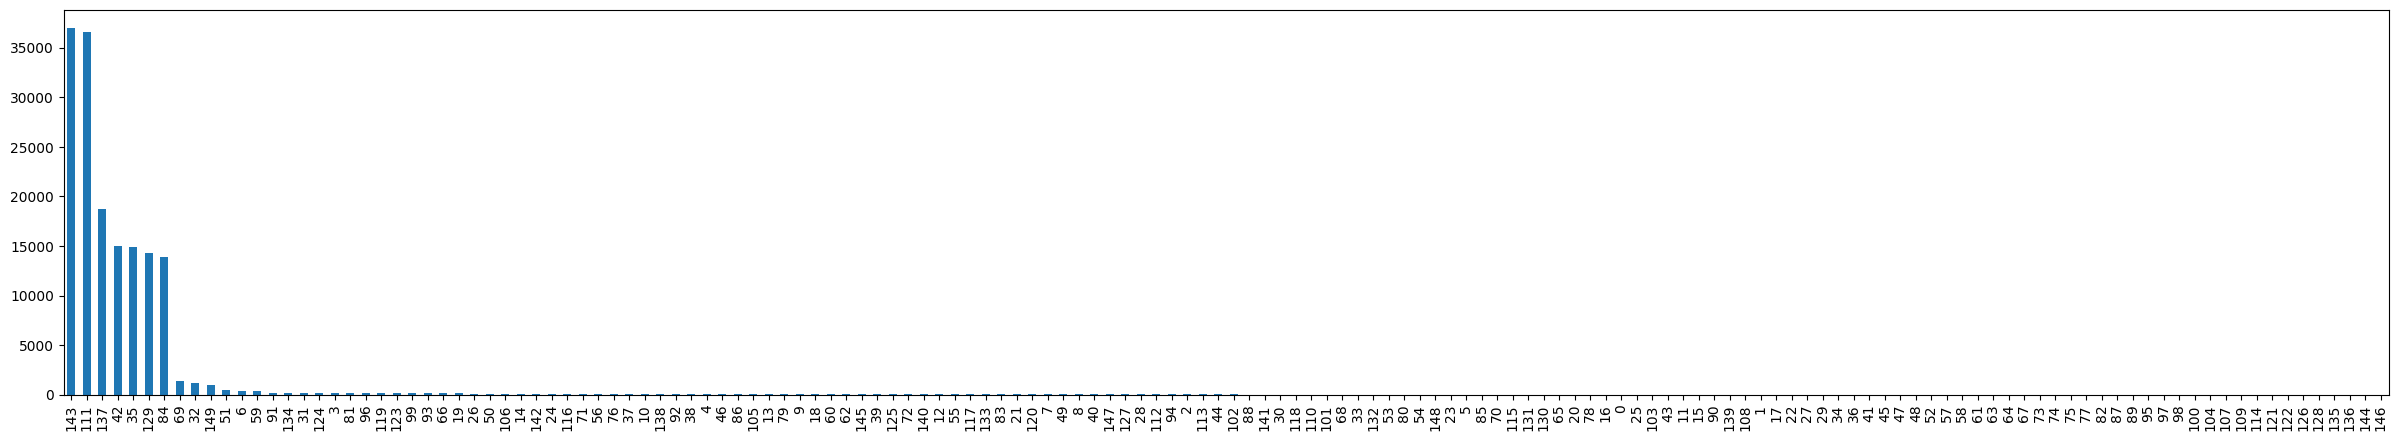

In [338]:
sample_6['distance'].sort_values(ascending=False).plot.bar(figsize=(30,5))

In [339]:
pd.set_option('display.max_rows', None)

El 16% de la muestra aleatoria del sexto dataframe (df_def_base_proyecto) no pudo ser georeferenciada por las siguientes razones:

* Nombres de vías que no son aceptados por el API
* Detalles de texto en la dirección
* Referencia a lugares especificos (no direcciones)

Hay un 10% adicional que hace referencia a direcciones fuera de Bogotá (en otras ciudades o en vías nacionales)

Adicionalmente, en este dataframe se contaba con coordenadas reales de referencia. En la revisión de los datos, el geocodificador muestra una alta presición. El 19% de los casos se ubicaron a mas de 100 metros de la coordenada original.

## Procesamiento

In [ ]:
df_vivienda_usada_venta['geocode_result'] = df_vivienda_usada_venta[vivienda_usada_dir].swifter.apply(georeferenciar)

In [217]:
pd.set_option('display.max_colwidth', 50)

In [189]:
# Caso especial que parte de un xlsx intermedio (por eso es diferente a los samples)
df_vivienda_usada_venta['estado'] = df_vivienda_usada_venta.apply(lambda x: json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['estado'] if type(x['geocode_result']) is str else x['geocode_result']['estado'], axis=1)
df_vivienda_usada_venta['tipo_direccion'] = df_vivienda_usada_venta.apply(lambda x: None if 'tipo_direccion' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['tipo_direccion'] if type(x['geocode_result']) is str else x['geocode_result']['tipo_direccion'], axis=1)
df_vivienda_usada_venta['lat'] = df_vivienda_usada_venta.apply(lambda x: None if 'yinput' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['yinput'] if type(x['geocode_result']) is str else x['geocode_result']['yinput'], axis=1)
df_vivienda_usada_venta['lng'] = df_vivienda_usada_venta.apply(lambda x: None if 'xinput' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['xinput'] if type(x['geocode_result']) is str else x['geocode_result']['xinput'], axis=1)

In [268]:
df_vivienda_usada_venta['estado'].value_counts(normalize=True)

estado
success     0.993987
failed      0.005876
error_ws    0.000137
Name: proportion, dtype: float64

In [11]:
df_vivienda_usada_arriendo['geocode_result'] = df_vivienda_usada_arriendo[vivienda_usada_dir].swifter.apply(georeferenciar)

Pandas Apply:   0%|          | 0/38301 [00:00<?, ?it/s]

In [198]:
# Caso especial que parte de un xlsx intermedio (por eso es diferente a los samples)
df_vivienda_usada_arriendo['estado'] = df_vivienda_usada_arriendo.apply(lambda x: json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['estado'] if type(x['geocode_result']) is str else x['geocode_result']['estado'], axis=1)
df_vivienda_usada_arriendo['tipo_direccion'] = df_vivienda_usada_arriendo.apply(lambda x: None if 'tipo_direccion' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['tipo_direccion'] if type(x['geocode_result']) is str else x['geocode_result']['tipo_direccion'], axis=1)
df_vivienda_usada_arriendo['lat'] = df_vivienda_usada_arriendo.apply(lambda x: None if 'yinput' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['yinput'] if type(x['geocode_result']) is str else x['geocode_result']['yinput'], axis=1)
df_vivienda_usada_arriendo['lng'] = df_vivienda_usada_arriendo.apply(lambda x: None if 'xinput' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['xinput'] if type(x['geocode_result']) is str else x['geocode_result']['xinput'], axis=1)

In [269]:
df_vivienda_usada_arriendo['estado'].value_counts(normalize=True)

estado
success     0.981410
error_ws    0.013289
failed      0.005300
Name: proportion, dtype: float64

In [13]:
df_comercio_base_proyecto['geocode_result'] = df_comercio_base_proyecto[comercio_dir].swifter.apply(georeferenciar)

Pandas Apply:   0%|          | 0/1071 [00:00<?, ?it/s]

In [211]:
# Caso especial que parte de un xlsx intermedio (por eso es diferente a los samples)
df_comercio_base_proyecto['estado'] = df_comercio_base_proyecto.apply(lambda x: json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['estado'] if type(x['geocode_result']) is str else x['geocode_result']['estado'], axis=1)
df_comercio_base_proyecto['tipo_direccion'] = df_comercio_base_proyecto.apply(lambda x: None if 'tipo_direccion' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['tipo_direccion'] if type(x['geocode_result']) is str else x['geocode_result']['tipo_direccion'], axis=1)
df_comercio_base_proyecto['lat'] = df_comercio_base_proyecto.apply(lambda x: None if 'yinput' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['yinput'] if type(x['geocode_result']) is str else x['geocode_result']['yinput'], axis=1)
df_comercio_base_proyecto['lng'] = df_comercio_base_proyecto.apply(lambda x: None if 'xinput' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['xinput'] if type(x['geocode_result']) is str else x['geocode_result']['xinput'], axis=1)

In [270]:
df_comercio_base_proyecto['estado'].value_counts(normalize=True)

estado
success    0.587302
failed     0.412698
Name: proportion, dtype: float64

In [276]:
df_comercio_base_proyecto[df_comercio_base_proyecto['Ciudad']=='Bogota']['estado'].value_counts(normalize=True)

estado
success    0.587302
failed     0.412698
Name: proportion, dtype: float64

In [14]:
df_comercio_base_inmuebles['geocode_result'] = df_comercio_base_inmuebles[comercio_dir].swifter.apply(georeferenciar)

Pandas Apply:   0%|          | 0/7654 [00:00<?, ?it/s]

In [223]:
# Caso especial que parte de un xlsx intermedio (por eso es diferente a los samples)
df_comercio_base_inmuebles['estado'] = df_comercio_base_inmuebles.apply(lambda x: json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['estado'] if type(x['geocode_result']) is str else x['geocode_result']['estado'], axis=1)
df_comercio_base_inmuebles['tipo_direccion'] = df_comercio_base_inmuebles.apply(lambda x: None if 'tipo_direccion' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['tipo_direccion'] if type(x['geocode_result']) is str else x['geocode_result']['tipo_direccion'], axis=1)
df_comercio_base_inmuebles['lat'] = df_comercio_base_inmuebles.apply(lambda x: None if 'yinput' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['yinput'] if type(x['geocode_result']) is str else x['geocode_result']['yinput'], axis=1)
df_comercio_base_inmuebles['lng'] = df_comercio_base_inmuebles.apply(lambda x: None if 'xinput' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['xinput'] if type(x['geocode_result']) is str else x['geocode_result']['xinput'], axis=1)

In [271]:
df_comercio_base_inmuebles['estado'].value_counts(normalize=True)

estado
success    0.606088
failed     0.393912
Name: proportion, dtype: float64

In [15]:
df_comercio_base_historia['geocode_result'] = df_comercio_base_historia[comercio_dir].swifter.apply(georeferenciar)

Pandas Apply:   0%|          | 0/1071 [00:00<?, ?it/s]

In [227]:
# Caso especial que parte de un xlsx intermedio (por eso es diferente a los samples)
df_comercio_base_historia['estado'] = df_comercio_base_historia.apply(lambda x: json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['estado'] if type(x['geocode_result']) is str else x['geocode_result']['estado'], axis=1)
df_comercio_base_historia['tipo_direccion'] = df_comercio_base_historia.apply(lambda x: None if 'tipo_direccion' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['tipo_direccion'] if type(x['geocode_result']) is str else x['geocode_result']['tipo_direccion'], axis=1)
df_comercio_base_historia['lat'] = df_comercio_base_historia.apply(lambda x: None if 'yinput' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['yinput'] if type(x['geocode_result']) is str else x['geocode_result']['yinput'], axis=1)
df_comercio_base_historia['lng'] = df_comercio_base_historia.apply(lambda x: None if 'xinput' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['xinput'] if type(x['geocode_result']) is str else x['geocode_result']['xinput'], axis=1)

In [272]:
df_comercio_base_historia['estado'].value_counts(normalize=True)

estado
success    0.587302
failed     0.412698
Name: proportion, dtype: float64

In [16]:
df_def_base_proyecto['geocode_result'] = df_def_base_proyecto[def_dir].swifter.apply(georeferenciar)

Pandas Apply:   0%|          | 0/5311 [00:00<?, ?it/s]

In [234]:
# Caso especial que parte de un xlsx intermedio (por eso es diferente a los samples)
df_def_base_proyecto['estado'] = df_def_base_proyecto.apply(lambda x: json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['estado'] if type(x['geocode_result']) is str else x['geocode_result']['estado'], axis=1)
df_def_base_proyecto['tipo_direccion'] = df_def_base_proyecto.apply(lambda x: None if 'tipo_direccion' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['tipo_direccion'] if type(x['geocode_result']) is str else x['geocode_result']['tipo_direccion'], axis=1)
df_def_base_proyecto['lat'] = df_def_base_proyecto.apply(lambda x: None if 'yinput' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['yinput'] if type(x['geocode_result']) is str else x['geocode_result']['yinput'], axis=1)
df_def_base_proyecto['lng'] = df_def_base_proyecto.apply(lambda x: None if 'xinput' not in json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0','')) else json.loads(x['geocode_result'].replace("'",'"').replace('\\xa0',''))['xinput'] if type(x['geocode_result']) is str else x['geocode_result']['xinput'], axis=1)

In [273]:
df_def_base_proyecto['estado'].value_counts(normalize=True)

estado
success     0.768217
failed      0.231407
error_ws    0.000377
Name: proportion, dtype: float64

## Generación de resultados

### XLSX

In [ ]:
df_vivienda_usada_venta.to_excel('MAYO/df_vivienda_usada_venta_v3.xlsx')

In [ ]:
df_vivienda_usada_arriendo.to_excel('MAYO/df_vivienda_usada_arriendo_v3.xlsx')

In [ ]:
df_comercio_base_proyecto.to_excel('MAYO/df_comercio_base_proyecto_v3.xlsx')

In [ ]:
df_comercio_base_inmuebles.to_excel('MAYO/df_comercio_base_inmuebles_v3.xlsx')

In [ ]:
df_comercio_base_historia.to_excel('MaAYO/df_comercio_base_historia_v3.xlsx')

In [ ]:
df_def_base_proyecto.to_excel('MAYO/df_def_base_proyecto_v3.xlsx')

### CSV

In [245]:
df_vivienda_usada_venta.to_csv('MAYO/df_vivienda_usada_venta_v3.csv')

In [237]:
df_vivienda_usada_arriendo.to_csv('MAYO/df_vivienda_usada_arriendo_v3.csv')

In [238]:
df_comercio_base_proyecto.to_csv('MAYO/df_comercio_base_proyecto_v3.csv')

In [239]:
df_comercio_base_inmuebles.to_csv('MAYO/df_comercio_base_inmuebles_v3.csv')

In [241]:
df_comercio_base_historia.to_csv('MAYO/df_comercio_base_historia_v3.csv')

In [242]:
df_def_base_proyecto.to_csv('MAYO/df_def_base_proyecto_v3.csv')

### Geojson

In [243]:
df_vivienda_usada_venta['geocoded_geom'] = df_vivienda_usada_venta.apply(lambda x: Point(x['lng'],x['lat']), axis=1)
gpd.GeoDataFrame(df_vivienda_usada_venta, geometry='geocoded_geom', crs="EPSG:4326").to_file('MAYO/df_vivienda_usada_venta_v3.geojson', driver="GeoJSON")

In [247]:
df_vivienda_usada_arriendo['geocoded_geom'] = df_vivienda_usada_arriendo.apply(lambda x: Point(x['lng'],x['lat']), axis=1)
gpd.GeoDataFrame(df_vivienda_usada_arriendo, geometry='geocoded_geom', crs="EPSG:4326").to_file('MAYO/df_vivienda_usada_arriendo_v3.geojson', driver="GeoJSON")

In [248]:
df_comercio_base_proyecto['geocoded_geom'] = df_comercio_base_proyecto.apply(lambda x: Point(x['lng'],x['lat']), axis=1)
gpd.GeoDataFrame(df_comercio_base_proyecto, geometry='geocoded_geom', crs="EPSG:4326").to_file('MAYO/df_comercio_base_proyecto_v3.geojson', driver="GeoJSON")

In [250]:
df_comercio_base_inmuebles['geocoded_geom'] = df_comercio_base_inmuebles.apply(lambda x: Point(x['lng'],x['lat']), axis=1)
gpd.GeoDataFrame(df_comercio_base_inmuebles, geometry='geocoded_geom', crs="EPSG:4326").to_file('MAYO/df_comercio_base_inmuebles_v3.geojson', driver="GeoJSON")

In [251]:
df_comercio_base_historia['geocoded_geom'] = df_comercio_base_historia.apply(lambda x: Point(x['lng'],x['lat']), axis=1)
gpd.GeoDataFrame(df_comercio_base_historia, geometry='geocoded_geom', crs="EPSG:4326").to_file('MAYO/df_comercio_base_historia_v3.geojson', driver="GeoJSON")

In [266]:
df_def_base_proyecto['geocoded_geom'] = df_def_base_proyecto.apply(lambda x: Point(x['lng'],x['lat']), axis=1)

In [ ]:
del df_def_base_proyecto['Dg(*)']
del df_def_base_proyecto['84(*)']
del df_def_base_proyecto['A']
del df_def_base_proyecto['Bis']
del df_def_base_proyecto['B']
del df_def_base_proyecto['Sur']
del df_def_base_proyecto['No. 8(*)']
del df_def_base_proyecto['C']
del df_def_base_proyecto[-62]
del df_def_base_proyecto['Este']

In [264]:
gpd.GeoDataFrame(df_def_base_proyecto, geometry='geocoded_geom', crs="EPSG:4326").to_file('MAYO/df_def_base_proyecto_v3.geojson', driver="GeoJSON")

In [267]:
df_def_base_proyecto['real_geom'] = df_def_base_proyecto.apply(lambda x: Point(x['Longitud\n(Coordenada Real)'],x['Latitud (Coordenada Real)']), axis=1)
del df_def_base_proyecto['geocoded_geom']
gpd.GeoDataFrame(df_def_base_proyecto, geometry='real_geom', crs="EPSG:4326").to_file('MAYO/df_def_base_proyecto_coord_real_v3.geojson', driver="GeoJSON")